## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
  

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [26]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [27]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
       BatchNorm1d-3                  [-1, 100]             200
         LeakyReLU-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,100
       BatchNorm1d-6                  [-1, 100]             200
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
         LeakyReLU-9                  [-1, 100]               0
           Linear-10                  [-1, 100]          10,100
      BatchNorm1d-11                  [-1, 100]             200
        LeakyReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 10]           1,010
       LogSoftmax-14                   

Your experiments come here:

In [28]:
def trainModel(model, loss_list, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        loss_list.append(running_loss / len(fmnist_dataset_train))

    print('Finished Training')

In [32]:
def checkAccuracy(model, loss_values):
    plt.title("Loss with training data")
    plt.plot(loss_values)
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total} %')


Finished Training
Accuracy of the network on the test images: 88.39 %


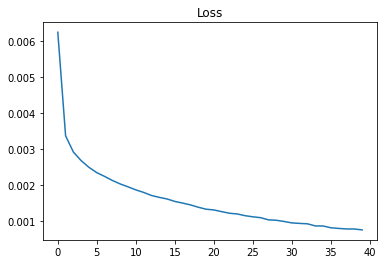

In [30]:
tinyModel = TinyNeuralNetwork().to(device)
tinyLoss_values = list()

# Your experiments, training and validation loops here
trainModel(tinyModel, tinyLoss_values, 40)
checkAccuracy(tinyModel, tinyLoss_values)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [34]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [35]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
         LeakyReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
         LeakyReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 200]          40,200
         LeakyReLU-7                  [-1, 200]               0
            Linear-8                  [-1, 200]          40,200
         LeakyReLU-9                  [-1, 200]               0
           Linear-10                  [-1, 200]          40,200
        LeakyReLU-11                  [-1, 200]               0
           Linear-12                  [-1, 200]          40,200
        LeakyReLU-13                  [-1, 200]               0
           Linear-14                   

Finished Training
Accuracy of the network on the test images: 85.76 %


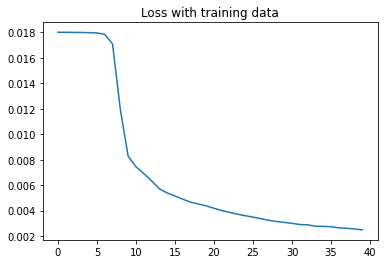

In [36]:
overfitting_model = OverfittingNeuralNetwork().to(device)
overfitting_loss_values = list()

# Your experiments, come here
trainModel(overfitting_model, overfitting_loss_values, 40)
checkAccuracy(overfitting_model, overfitting_loss_values)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [50]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(200, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [51]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
         LeakyReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                  [-1, 200]          40,200
         LeakyReLU-7                  [-1, 200]               0
            Linear-8                  [-1, 200]          40,200
         LeakyReLU-9                  [-1, 200]               0
           Linear-10                  [-1, 200]          40,200
        LeakyReLU-11                  [-1, 200]               0
           Linear-12                  [-1, 200]          40,200
        LeakyReLU-13                  [-1, 200]               0
           Linear-14                  [

Finished Training
Accuracy of the network on the test images: 86.43 %


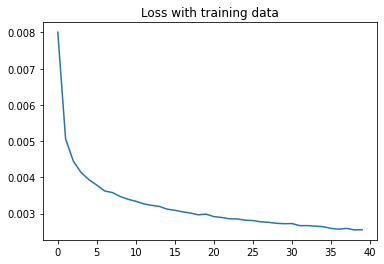

In [43]:
fixed_model = FixedNeuralNetwork().to(device)
fixed_loss_values = list()

# Your experiments, come here
trainModel(fixed_model, fixed_loss_values, 40)
checkAccuracy(fixed_model, fixed_loss_values)

### Conclusions:
_Write down small report with your conclusions and your ideas._

We found out that the model with linear layers does not cope with the task. Adding BatchNorm normalizes intermediate feature spaces, and Dropout makes the model more stable, which together leads to a good result.